In [21]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, concatenate
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
import cv2

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

from keras.callbacks import EarlyStopping

import random


from tensorflow.keras.callbacks import TensorBoard
import time

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from keras.regularizers import l2

In [22]:
NAME = f"dementia_2pipleline_augmented_sampled_{int(time.time())}"
tensorboard = TensorBoard(log_dir = "./logs/{}".format(NAME))

In [23]:
folder = "C:/Users/mohdf/OneDrive/Desktop/oasis/data/organised_mr"
excel_folder = "E:/Faheem/oasis-scripts-master/FaheemSirKaData2.csv"

# main = "C:/Users/mohdf/OneDrive/Desktop/oasis new/"
# folder = main + "small"
# excel_folder = main + "small_data.csv"

# 0 -> 0; 0.5 -> 1; 1 -> 2; 2 -> 3

zero = []
point5 = []
one = []
two = []
   
for dirname, _, filenames in os.walk(folder+'/0.0'):
    for filename in filenames:
        zero.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(folder+'/0.5'):
    for filename in filenames:
        point5.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(folder+'/1.0'):
    for filename in filenames:
        one.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(folder+'/2.0'):
    for filename in filenames:
        two.append(os.path.join(dirname, filename))




len(zero),len(point5),len(one),len(two)




(70603, 16233, 20738, 4517)

In [4]:
target_samples = 30000


def oversample(target_sample, image_list):
    # Define the number of original and duplicate samples
    original_samples = len(image_list)
    duplicate_samples = target_samples - original_samples
    
    # Sample 450 unique indices from your dataset
    original_indices = random.sample(range(len(image_list)), k=original_samples)
    
    # Select 50 random duplicates from the 450 original samples
    duplicate_indices = random.choices(original_indices, k=duplicate_samples)
    
    # Get the file paths of original and duplicate samples
    original_images = [image_list[i] for i in original_indices]
    duplicate_images = [image_list[i] for i in duplicate_indices]

    return duplicate_images

point5_sampled = oversample(target_samples,point5)
one_sampled = oversample(target_samples,one)
two_sampled = oversample(target_samples,two)

# undersample
zero_sampled = random.sample(zero, k=50000)


In [5]:
print(len(zero),len(point5),len(one),len(two))
print(len(zero_sampled),len(point5_sampled),len(one_sampled),len(two_sampled))
print(len(zero_sampled),len(point5)+len(point5_sampled),len(one)+len(one_sampled),len(two)+len(two_sampled))

70603 16233 20738 4517
50000 13767 9262 25483
50000 30000 30000 30000


In [6]:
image_paths = []
labels = []
image_names = []

# since zero is undersampled
for path in zero_sampled:
    name = path.split("/")[-1]
    name = "_".join(name.split("_")[0:3])
    name = name[4:]
    image_paths.append(path)
    labels.append(0)
    arr = [name,"original"]
    image_names.append(arr)
    
for path in point5_sampled:
    name = path.split("/")[-1]
    name = "_".join(name.split("_")[0:3])
    name = name[4:]
    image_paths.append(path)
    labels.append(1)
    arr = [name,"sampled"]
    image_names.append(arr)
    
for path in one_sampled:
    name = path.split("/")[-1]
    name = "_".join(name.split("_")[0:3])
    name = name[4:]
    image_paths.append(path)
    labels.append(2)
    arr = [name,"sampled"]
    image_names.append(arr)

for path in two_sampled:
    name = path.split("/")[-1]
    name = "_".join(name.split("_")[0:3])
    name = name[4:]
    image_paths.append(path)
    labels.append(3)
    arr = [name,"sampled"]
    image_names.append(arr)
    
for path in point5:
    name = path.split("/")[-1]
    name = "_".join(name.split("_")[0:3])
    name = name[4:]
    image_paths.append(path)
    labels.append(1)
    arr = [name,"original"]
    image_names.append(arr)
    
for path in one:
    name = path.split("/")[-1]
    name = "_".join(name.split("_")[0:3])
    name = name[4:]
    image_paths.append(path)
    labels.append(2)
    arr = [name,"original"]
    image_names.append(arr)

for path in two:
    name = path.split("/")[-1]
    name = "_".join(name.split("_")[0:3])
    name = name[4:]
    image_paths.append(path)
    labels.append(3)
    arr = [name,"original"]
    image_names.append(arr)


image_paths = np.array(image_paths)
labels = np.array(labels)
image_names = np.array(image_names)

In [7]:
np.unique(image_names[:,1], return_counts=True)

(array(['original', 'sampled'], dtype='<U17'),
 array([91488, 48512], dtype=int64))

In [8]:
train_images, test_images, train_labels, test_labels, train_names, test_names = train_test_split(
    image_paths, labels, image_names, test_size=0.2, random_state=42
)
train_images, val_images, train_labels, val_labels, train_names, val_names = train_test_split(
    train_images, train_labels, train_names, test_size=0.25, random_state=42
)

def image_generator(image_paths, image_names,labels, batch_size=32):
    while True:
        for i in range(0, len(image_paths), batch_size):
            image_batch = image_paths[i:i+batch_size]
            image_name_batch = image_names[i:i+batch_size]
            label_batch = labels[i:i+batch_size]
            
            df = pd.read_csv(excel_folder)
            patient_id = df["MR ID"].values

            matched_images = []
            matched_labels = []
            matched_csv = []
            matched_type = []

            
            for j, arr in enumerate(image_name_batch):
                img_id = arr[0]
                img_type = arr[1]
                if img_id in patient_id:
                    matched_images.append(image_batch[j])
                    matched_labels.append(label_batch[j])
                    matched_csv.append(df.loc[df["MR ID"] == img_id].drop(columns=["MR ID", "target","Subject","dx1_list2"]).values[0])
                    # matched_csv.append(df.loc[df["MR ID"] == img_id].drop(columns=["MR ID", "target"]).values[0])
                    matched_type.append(img_type)
                    
            
            matched_images = np.array(matched_images)
            matched_labels = np.array(matched_labels)
            matched_csv = np.array(matched_csv)
            matched_type = np.array(matched_type)
            
            # Load and process the images in this batch
            image_array = []
            for index,path in enumerate(matched_images):
                image = cv2.imread(path)
                if matched_type[index] == "sampled":
                    image = random_augment(image)
                image = cv2.resize(image, (256, 256))
                image_array.append(image)

            image_array = np.array(image_array)
            image_array = image_array / 255.0

            scaler = StandardScaler()
            matched_csv_normalized = scaler.fit_transform(matched_csv)
            matched_csv = matched_csv_normalized

            yield [image_array, matched_csv], to_categorical(matched_labels, num_classes=4)


# Create the generators for training, validation, and testing
train_generator = image_generator(train_images, train_names, train_labels)
val_generator = image_generator(val_images, val_names, val_labels)
test_generator = image_generator(test_images, test_names, test_labels)


In [9]:
# Define Augmentation Functions
def flip_horizontal(image):
  """Flips the image horizontally."""
  return cv2.flip(image, 1)  # 1 for horizontal flip

def flip_vertical(image):
  """Flips the image vertically."""
  return cv2.flip(image, 0)  # 0 for vertical flip

def rotate(image, angle):
  """Rotates the image by a given angle."""
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
  return cv2.warpAffine(image, rotation_matrix, (w, h))

def scale(image, scale_factor):
  """Scales the image by a given factor."""
  return cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)



def flip_augment(image):
  """Flips the image horizontally or vertically with random probability."""
  if random.random() > 0.5:
    return flip_horizontal(image)
  else:
    return flip_vertical(image)

def rotate_augment(image, angle_range=(-360, 360)):
  """Rotates the image by a random angle within a specified range."""
  angle = random.uniform(*angle_range)  # Random angle within the range
  return rotate(image, angle)

def scale_augment(image, scale_range=(0.5, 2)):
  """Scales the image by a random factor within a specified range."""
  scale_factor = random.uniform(*scale_range)  # Random scale factor within the range
  return scale(image, scale_factor)

def random_augment(image):
  """Applies random augmentation (flip, rotate, or scale) to the image."""
  augmentations = [flip_augment, rotate_augment, scale_augment]
  chosen_augment = random.choice(augmentations)
  return chosen_augment(image)

In [10]:
# # Define the CNN model
# image_input = Input(shape=(256, 256, 3))  # Updated shape based on the target_size
# csv_input = Input(shape=(580))
# # csv_input = Input(shape=(8))

# x = Conv2D(32, (3, 3), activation='relu')(image_input)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)
# x = Conv2D(64, (3, 3), activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)
# x = Conv2D(128, (3, 3), activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Flatten()(x)
# x = Dense(16, activation='relu')(x)
# x = Model(inputs=image_input, outputs=x)

# y = Dense(64, activation='relu')(csv_input)
# y = Dense(32, activation="relu")(y)
# y = Dense(16, activation="relu")(y)
# y = Model(inputs=csv_input, outputs=y)

# combined = concatenate([x.output, y.output])

# z = Dense(2, activation="relu")(combined)
# z = Dense(10, activation='relu')(z)
# output = Dense(4, activation='softmax')(z)


In [11]:
# Define the CNN model
image_input = Input(shape=(256, 256, 3))  # Updated shape based on the target_size
csv_input = Input(shape=(580))

# CNN layers
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)  # Adding L2 regularization
x = Dropout(0.5)(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)  # Adding L2 regularization
x = Model(inputs=image_input, outputs=x)

# CSV input layers
y = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(csv_input)  # Adding L2 regularization
y = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(y)  # Adding L2 regularization
y = Dense(16, activation="relu", kernel_regularizer=l2(0.001))(y)  # Adding L2 regularization
y = Model(inputs=csv_input, outputs=y)

# Combined model
combined = concatenate([x.output, y.output])

z = Dense(2, activation="relu", kernel_regularizer=l2(0.001))(combined)  # Adding L2 regularization
z = Dense(10, activation='relu', kernel_regularizer=l2(0.001))(z)  # Adding L2 regularization
output = Dense(4, activation='softmax', kernel_regularizer=l2(0.001))(z)  # Adding L2 regularization

In [12]:
model = Model(inputs=[image_input,csv_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision(),'accuracy'])

In [13]:

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

batch_size = 32
steps_per_epoch = len(train_images) // batch_size 
validation_steps = len(val_images) // batch_size 

history = model.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    validation_data= ( val_generator),
    validation_steps = validation_steps,
    epochs=10,
    callbacks=[tensorboard,early_stopping]
)



Epoch 1/10
2625/2625 [==============================] - 1634s 619ms/step - loss: 0.2898 - precision: 0.9912 - accuracy: 0.9289 - val_loss: 0.0798 - val_precision: 0.9968 - val_accuracy: 0.9965
Epoch 2/10
2625/2625 [==============================] - 1609s 613ms/step - loss: 0.0691 - precision: 0.9972 - accuracy: 0.9971 - val_loss: 0.0579 - val_precision: 0.9982 - val_accuracy: 0.9981
Epoch 3/10
2625/2625 [==============================] - 1613s 615ms/step - loss: 0.0578 - precision: 0.9977 - accuracy: 0.9976 - val_loss: 0.0500 - val_precision: 0.9988 - val_accuracy: 0.9987
Epoch 4/10
2625/2625 [==============================] - 1616s 616ms/step - loss: 0.0517 - precision: 0.9980 - accuracy: 0.9979 - val_loss: 0.0457 - val_precision: 0.9989 - val_accuracy: 0.9989
Epoch 5/10
2625/2625 [==============================] - 1634s 622ms/step - loss: 0.0478 - precision: 0.9984 - accuracy: 0.9983 - val_loss: 0.0421 - val_precision: 0.9993 - val_accuracy: 0.9993
Epoch 6/10
2625/2625 [=============

In [14]:
# # Evaluate the model
# test_steps = len(test_images) // batch_size 
# loss, accuracy = model.evaluate(test_generator, steps=test_steps)
# print(f"Test Loss: {loss}")
# print(f"Test Accuracy: {accuracy}")

In [15]:
test_steps = len(test_images) // batch_size 
loss_and_metrics = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {loss_and_metrics[0]}")
print(f"Test Accuracy: {loss_and_metrics[1]}")

875/875 [==============================] - 403s 461ms/step - loss: 0.0388 - precision: 0.9993 - accuracy: 0.9992
Test Loss: 0.038760799914598465
Test Accuracy: 0.9992856383323669


In [16]:
loss_and_metrics

[0.038760799914598465, 0.9992856383323669, 0.9992499947547913]

In [17]:
# Predictions
test_steps = len(test_images) // batch_size
predictions = model.predict(test_generator, steps=test_steps)

# Convert predictions from one-hot to categorical labels
predicted_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = []
for i in range(test_steps):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Classification Report
class_names = ['0', '1', '2', '3']
report = classification_report(true_labels, predicted_labels, target_names=class_names, labels=['0', '1', '2', '3'], zero_division=1)
print("Classification Report:")
print(report)

875/875 [==============================] - 402s 460ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.36      0.36     10105
           1       0.21      0.21      0.21      5946
           2       0.21      0.21      0.21      5974
           3       0.22      0.22      0.22      5975

   micro avg       0.26      0.26      0.26     28000
   macro avg       0.25      0.25      0.25     28000
weighted avg       0.26      0.26      0.26     28000



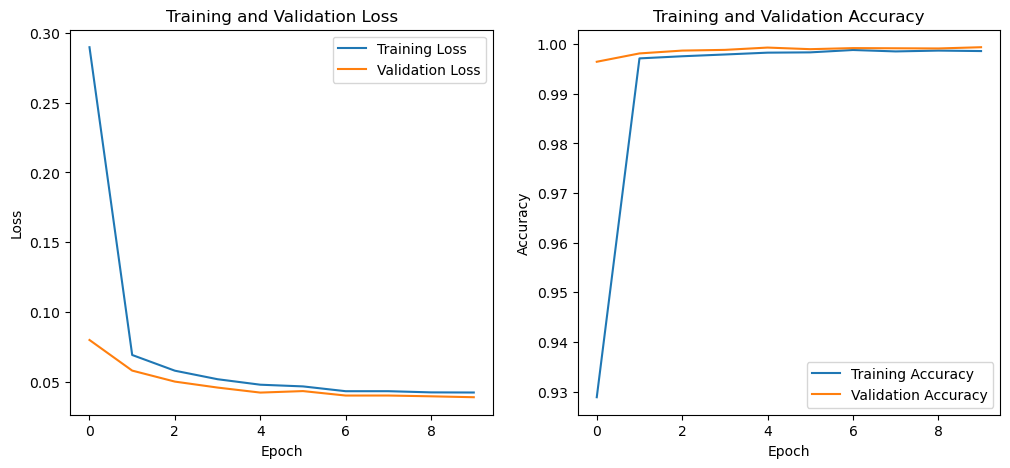

In [18]:
# Loss and Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

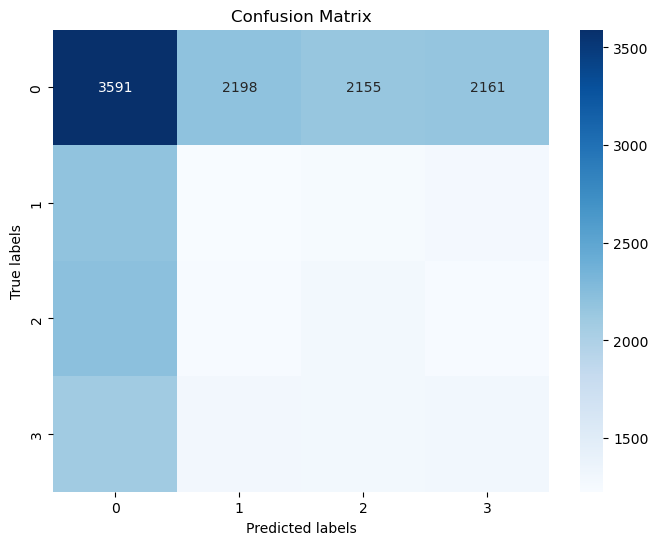

In [19]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [20]:
# Predictions
test_steps = len(test_images) // batch_size
predictions = model.predict(test_generator, steps=test_steps)

# True labels
true_labels = []
for i in range(test_steps):
    _, labels = next(test_generator)
    true_labels.extend(labels)

roc_auc = roc_auc_score(true_labels, predictions, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

875/875 [==============================] - 402s 460ms/step
ROC-AUC Score: 0.4979544991168429
